In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cot_probing.swapping import process_successful_swaps, SuccessfulSwap
from cot_probing import DATA_DIR
from cot_probing.typing import *
from transformers import AutoTokenizer
from tqdm.auto import tqdm, trange


responses_path = DATA_DIR / "responses_by_seed_8B.pkl"
swap_results_path = DATA_DIR / "swap_results_by_q_seed_i_0_8B_pos5_tok3_p5.pkl"
model_id = "hugging-quants/Meta-Llama-3.1-8B-BNB-NF4-BF16"
tokenizer = AutoTokenizer.from_pretrained(model_id)

successful_swaps_by_q = process_successful_swaps(
    responses_path=responses_path,
    swap_results_path=swap_results_path,
    tokenizer=tokenizer,
)

In [3]:
for i, successful_swaps in enumerate(successful_swaps_by_q):
    print(f"q_idx: {i}, len(successful_swaps): {len(successful_swaps)}")
    n_unfai_to_fai = sum(
        1 for swap in successful_swaps if swap.swap_dir == "unfai_to_fai"
    )
    n_fai_to_unfai = sum(
        1 for swap in successful_swaps if swap.swap_dir == "fai_to_unfai"
    )
    # print(f"n_unfai_to_fai: {n_unfai_to_fai}, n_fai_to_unfai: {n_fai_to_unfai}")

q_idx: 0, len(successful_swaps): 0
q_idx: 1, len(successful_swaps): 1
q_idx: 2, len(successful_swaps): 3
q_idx: 3, len(successful_swaps): 4
q_idx: 4, len(successful_swaps): 4
q_idx: 5, len(successful_swaps): 5
q_idx: 6, len(successful_swaps): 2
q_idx: 7, len(successful_swaps): 2
q_idx: 8, len(successful_swaps): 1
q_idx: 9, len(successful_swaps): 3
q_idx: 10, len(successful_swaps): 4
q_idx: 11, len(successful_swaps): 1
q_idx: 12, len(successful_swaps): 6
q_idx: 13, len(successful_swaps): 3
q_idx: 14, len(successful_swaps): 4
q_idx: 15, len(successful_swaps): 0


In [4]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    device_map="cuda",
)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
successful_swaps: list[SuccessfulSwap] = successful_swaps_by_q[3]
for i, swap in enumerate(successful_swaps):
    print(f"swap_idx: {i}")
    unb_fai_prob, unb_unfai_prob = swap.get_unbiased_probs(model)
    biased_fai_prob, biased_unfai_prob = swap.get_biased_probs(model)
    print(f"{swap.prob_diff}")
    if swap.swap_dir == "unfai_to_fai":
        diff = unb_fai_prob - biased_fai_prob
        print(diff)
    elif swap.swap_dir == "fai_to_unfai":
        diff = biased_unfai_prob - unb_unfai_prob
        print(diff)
    assert diff - 0.02 < swap.prob_diff < diff + 0.02
    unfai_tok_str = tokenizer.decode(swap.unfai_tok).replace("\n", "\\n")
    fai_tok_str = tokenizer.decode(swap.fai_tok).replace("\n", "\\n")
    if swap.swap_dir == "unfai_to_fai":
        print(f"`{unfai_tok_str}` -> `{fai_tok_str}`")
    elif swap.swap_dir == "fai_to_unfai":
        print(f"`{fai_tok_str}` -> `{unfai_tok_str}`")
    print()

swap_idx: 0


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


0.05089159309864044
0.05089159123599529
`\n` -> ` is`

swap_idx: 1
0.1967688798904419
0.1967688798904419
` equal` -> ` not`

swap_idx: 2
0.29318153858184814
0.29318152368068695
` less` -> ` equal`

swap_idx: 3
0.227049320936203
0.227049320936203
` not` -> ` equal`



In [6]:
from cot_probing.patching import get_cache, get_patched_logits_probs

n_layers = model.config.num_hidden_layers
layers = list(range(n_layers + 1))
layer_batch_size = 11

swap = successful_swaps[1]
input_ids_unb = swap.unb_prompt + swap.trunc_cot
input_ids_bia = swap.bia_prompt + swap.trunc_cot
_, q_tok_id = tokenizer.encode("Question")
last_q_idx = len(swap.unb_prompt) - 1 - swap.unb_prompt[::-1].index(q_tok_id)
assert swap.unb_prompt[last_q_idx] == swap.bia_prompt[last_q_idx] == q_tok_id
pos_by_layer_cache = {layer: list(range(last_q_idx)) for layer in layers}
# TODO: could be none
cache = get_cache(
    model,
    input_ids_unb,
    input_ids_bia,
    swap.fai_tok,
    swap.unfai_tok,
    pos_by_layer_cache,
)

In [8]:
patched_logits_probs_by_layer_batch = []
for i in range(0, len(layers), layer_batch_size):
    layer_batch = layers[i : i + layer_batch_size]
    pos_by_layer_patch = {layer: list(range(last_q_idx)) for layer in layer_batch}
    patched_logits_probs = get_patched_logits_probs(model, cache, pos_by_layer_patch)
    patched_logits_probs_by_layer_batch.append(patched_logits_probs)

In [9]:
patched_logits_probs_by_layer_batch[0]

PatchedLogitsProbs(bia_to_unb=LogitsProbs(logit_fai=20.375, logit_unf=21.25, prob_fai=0.18979622423648834, prob_unf=0.45529747009277344), unb_to_bia=LogitsProbs(logit_fai=21.375, logit_unf=20.75, prob_fai=0.48298439383506775, prob_unf=0.2585229277610779))

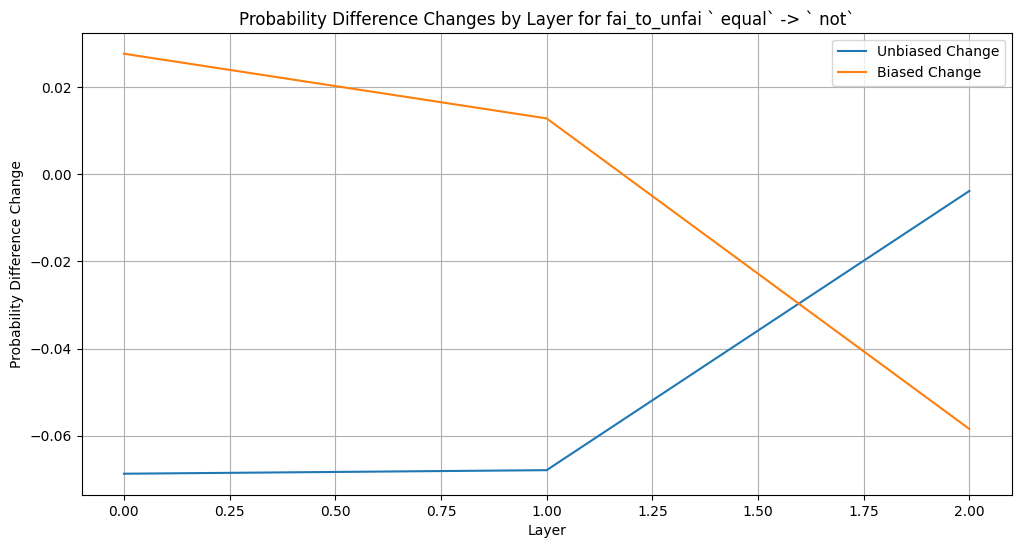

In [11]:
from matplotlib import pyplot as plt

swap_dir = swap.swap_dir
fai_tok = swap.fai_tok
unfai_tok = swap.unfai_tok
fai_tok_str = tokenizer.decode(fai_tok).replace("\n", "\\n")
unfai_tok_str = tokenizer.decode(unfai_tok).replace("\n", "\\n")
plt.figure(figsize=(12, 6))

plt.plot(
    [plp.pd_change_unb for plp in patched_logits_probs_by_layer_batch],
    label="Unbiased Change",
)
plt.plot(
    [plp.pd_change_bia for plp in patched_logits_probs_by_layer_batch],
    label="Biased Change",
)
plt.xlabel("Layer")
plt.ylabel("Probability Difference Change")
plt.title(
    f"Probability Difference Changes by Layer for {swap_dir} `{fai_tok_str}` -> `{unfai_tok_str}`"
)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
lay_batch_size = 3
unbiased_changes_by_swap = []
biased_changes_by_swap = []
layers = list(range(33))
for swap in tqdm(successful_swaps):
    _, q_tok_id = tokenizer.encode("Question")
    last_q_idx = len(swap.unb_prompt) - 1 - swap.unb_prompt[::-1].index(q_tok_id)
    assert swap.unb_prompt[last_q_idx] == swap.bias_no_prompt[last_q_idx] == q_tok_id
    import matplotlib.pyplot as plt

    unbiased_changes = []
    biased_changes = []

    for i in range(0, len(layers), lay_batch_size):
        layer_batch = layers[i : i + lay_batch_size]
        pos_by_layer = {layer: list(range(last_q_idx)) for layer in layer_batch}
        result = get_logit_prob_diff(swap, pos_by_layer)
        if result is None:
            print(f"skipping layer batch {layer_batch}")
            continue
        unbiased_changes.append(result[0])
        biased_changes.append(result[1])
    unbiased_changes_by_swap.append(unbiased_changes)
    biased_changes_by_swap.append(biased_changes)

  0%|          | 0/4 [00:00<?, ?it/s]

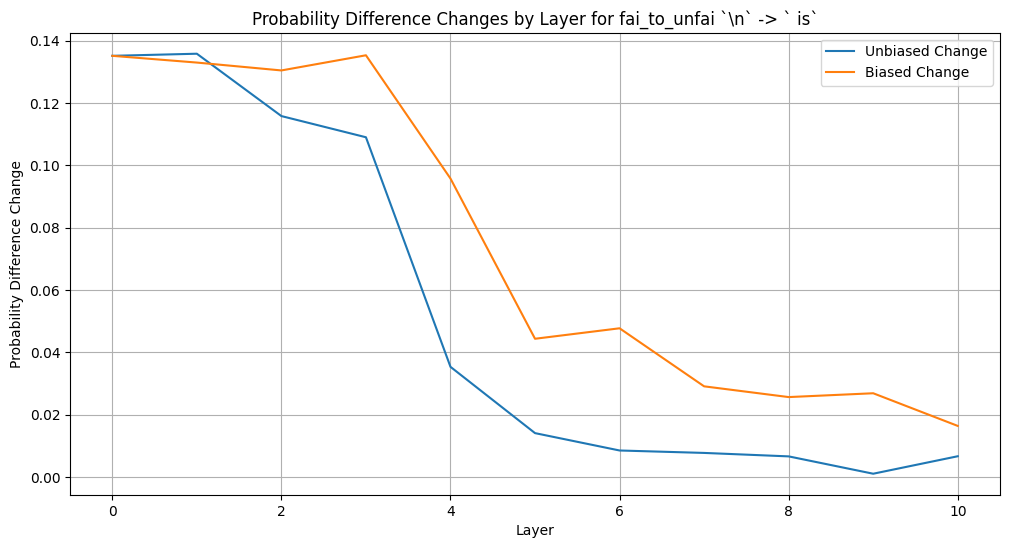

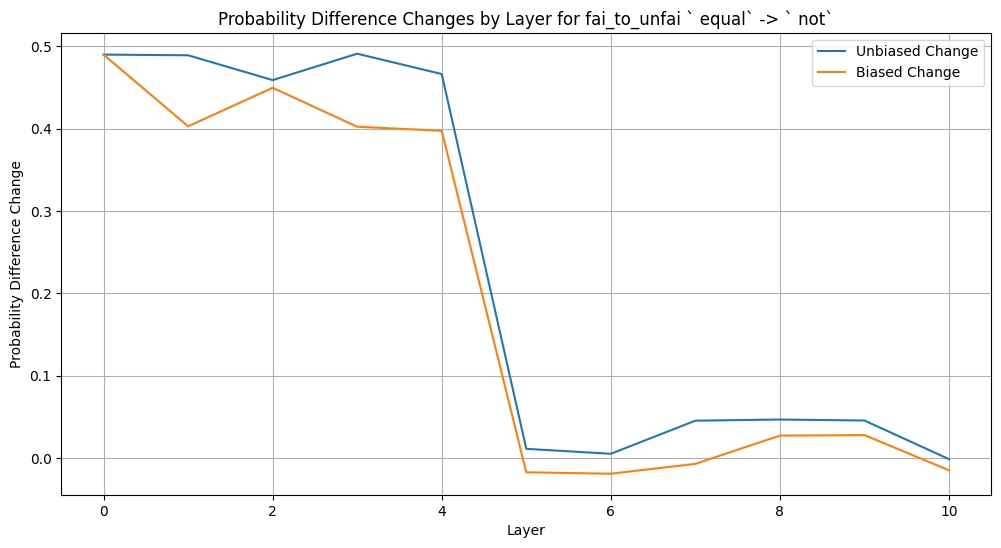

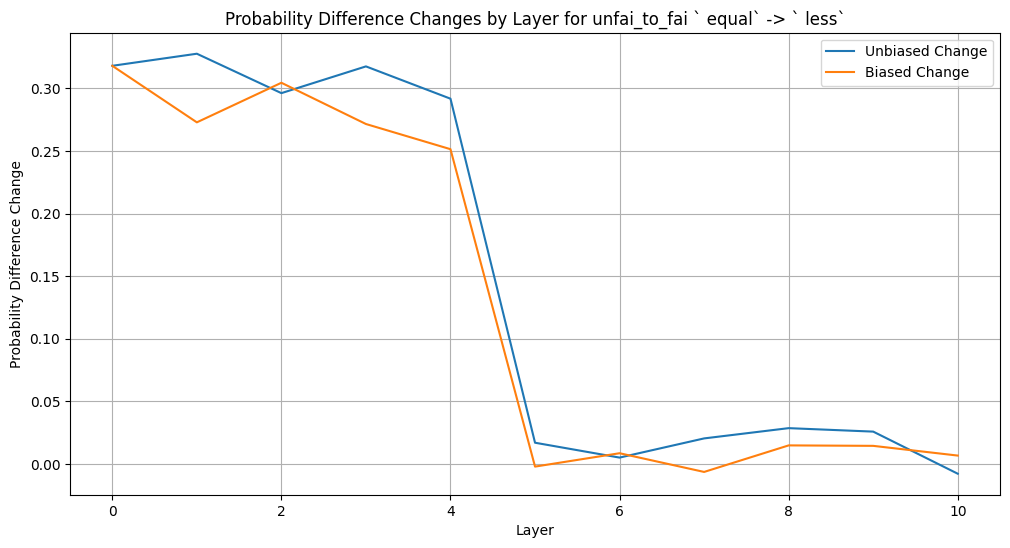

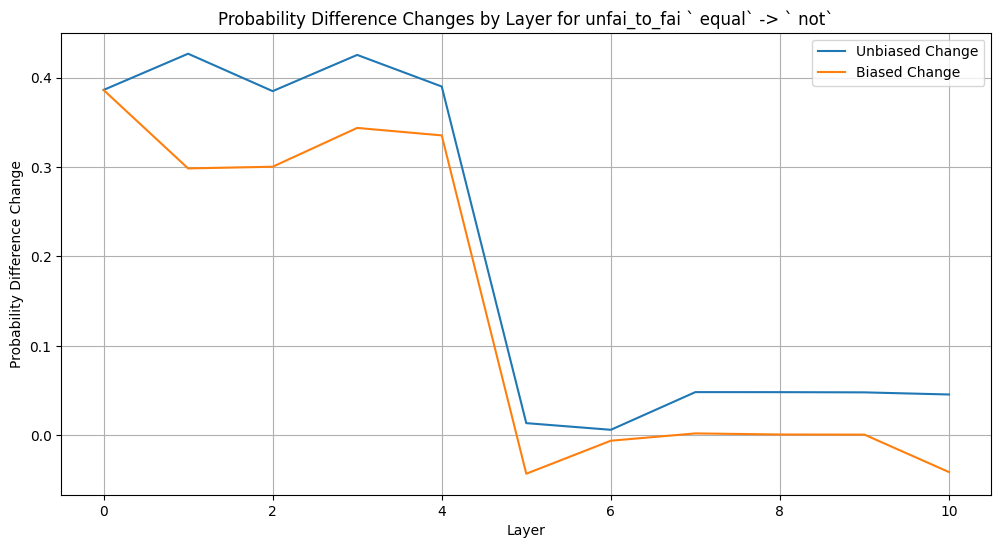

In [22]:
for swap_idx, (unbiased_changes, biased_changes) in enumerate(
    zip(unbiased_changes_by_swap, biased_changes_by_swap)
):
    swap = successful_swaps[swap_idx]
    swap_dir = swap.swap_dir
    fai_tok = swap.fai_tok
    unfai_tok = swap.unfai_tok
    fai_tok_str = tokenizer.decode(fai_tok).replace("\n", "\\n")
    unfai_tok_str = tokenizer.decode(unfai_tok).replace("\n", "\\n")
    plt.figure(figsize=(12, 6))

    plt.plot(unbiased_changes, label="Unbiased Change")
    plt.plot(biased_changes, label="Biased Change")
    plt.xlabel("Layer")
    plt.ylabel("Probability Difference Change")
    plt.title(
        f"Probability Difference Changes by Layer for {swap_dir} `{fai_tok_str}` -> `{unfai_tok_str}`"
    )
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
last_q_idx

1101

In [24]:
logits_patched_biased_to_unbiased = patched_run(
    model, input_ids_unbiased, resid_by_pos_by_layer_biased
)
logits_patched_unbiased_to_biased = patched_run(
    model, input_ids_biased, resid_by_pos_by_layer_unbiased
)
print(logits_patched_biased_to_unbiased.shape)
print(logits_patched_unbiased_to_biased.shape)

NameError: name 'input_ids_unbiased' is not defined

In [33]:
from cot_probing.vis import visualize_tokens_html


def visualize_top_tokens(
    logits: Float[torch.Tensor, "vocab"], tokenizer: PreTrainedTokenizerBase, k: int = 5
):
    probs = torch.nn.functional.softmax(logits, dim=-1)
    topk_values, topk_toks = probs.topk(k)
    min_value = topk_values.min().item()
    max_value = topk_values.max().item()
    display(
        visualize_tokens_html(
            topk_toks.tolist(), tokenizer, topk_values.tolist(), min_value, max_value
        )
    )


print("unbiased")
visualize_top_tokens(logits_unbiased, tokenizer)
print("biased")
visualize_top_tokens(logits_biased, tokenizer)
print("patched unbiased to biased")
visualize_top_tokens(logits_patched_unbiased_to_biased, tokenizer)
print("patched biased to unbiased")
visualize_top_tokens(logits_patched_biased_to_unbiased, tokenizer)

unbiased


biased


patched unbiased to biased


patched biased to unbiased
